## Importing Libraries and Files

In [1]:
import numpy as np
import pandas as pd 
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# for text preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

train_data = pd.read_csv("/kaggle/input/phm-dataset/phm_train.csv")
test_data = pd.read_csv("/kaggle/input/phm-dataset/phm_test.csv")

# print(train_data.head())


2025-06-09 10:33:57.895406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749465238.338863      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749465238.435553      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # remove url
    tweet = re.sub(r'[^\w\s]', '', tweet)        # remove punctuations
    tweet = re.sub(r'<.*?>', '', tweet)          # remove html tag
    tweet = re.sub(r'[^A-Za-z]', ' ', tweet)     # remove non alphabet
    tweet = tweet.lower()                        # make it all lower case
    
    # remove stopwords
    filtered_words = [lemmatizer.lemmatize(w) for w in tweet.split() if w not in stop_words]

    return " ".join(filtered_words)

In [3]:
X_train = train_data['tweet'].apply(preprocess_tweet)
X_test = test_data['tweet'].apply(preprocess_tweet)

Y_train = train_data['label']
Y_test = test_data['label']

#X_train.head()
#Y_train.head()

## Tokenize and Pad/Truncate

In [4]:
def get_max_length():
    review_length = []
    for review in X_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [5]:
max_length = get_max_length()   # max length of a tweet
embedding_dim = 64 # dimension of the word embeddings

# Initialize and fit the tokenizer
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

word_index = tokenizer.word_index
total_words = len(tokenizer.word_index) + 1

print(f"\nFound {len(word_index)} unique tokens.")
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of Y_train:", Y_train.shape)

print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of Y_test:", Y_test.shape)


Found 11677 unique tokens.
Shape of X_train_pad: (9991, 60)
Shape of Y_train: (9991,)
Shape of X_test_pad: (3331, 60)
Shape of Y_test: (3331,)


# MODEL 1 : LSTM

In [6]:
LSTM_OUT = 64
EPOCHS = 10
BATCH = 16

lstm_model = Sequential([
    Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=LSTM_OUT, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Define callbacks
# Save the best model during training
lstm_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train Model
history_lstm = lstm_model.fit(
    X_train_pad, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_test_pad, Y_test),
    callbacks=[lstm_checkpoint, early_stopping]
)
lstm_model.summary()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-09 10:34:20.992333: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6769 - loss: 0.6291
Epoch 1: val_accuracy improved from -inf to 0.70970, saving model to best_lstm_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.6770 - loss: 0.6291 - val_accuracy: 0.7097 - val_loss: 0.6028
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7057 - loss: 0.6083
Epoch 2: val_accuracy did not improve from 0.70970
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7057 - loss: 0.6083 - val_accuracy: 0.7097 - val_loss: 0.6049
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7138 - loss: 0.6011
Epoch 3: val_accuracy did not improve from 0.70970
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7138 - loss: 0.6011 - val_accuracy: 0.7097 - val_loss: 0.6025
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7053 - loss: 0.6080
Epoch 4: val_accuracy did not improve from 0.70970
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7053 - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 60, 64)              │         747,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,341,445 (8.93 MB)

 Trainable params: 780,481 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,560,964 (5.95 MB)

# MODEL 2: Bi-LSTM

In [7]:
LSTM_OUT = 64
EPOCHS = 10
BATCH = 16

bilstm_model = Sequential([

    Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=LSTM_OUT, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
bilstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Define callbacks 
bilstm_checkpoint = ModelCheckpoint('best_bilstm_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Train Model
history_bilstm = bilstm_model.fit(
    X_train_pad, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_test_pad, Y_test),
    callbacks=[bilstm_checkpoint, early_stopping]
)
bilstm_model.summary()

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6951 - loss: 0.6248
Epoch 1: val_accuracy improved from -inf to 0.70970, saving model to best_bilstm_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.6951 - loss: 0.6248 - val_accuracy: 0.7097 - val_loss: 0.5800
Epoch 2/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7208 - loss: 0.5502
Epoch 2: val_accuracy improved from 0.70970 to 0.79856, saving model to best_bilstm_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.7208 - loss: 0.5501 - val_accuracy: 0.7986 - val_loss: 0.4666
Epoch 3/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8094 - loss: 0.4295
Epoch 3: val_accuracy improved from 0.79856 to 0.82137, saving model to best_bilstm_model.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8095 - loss: 0.4294 - val_accuracy: 0.8214 - val_loss: 0.4071
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8608 - loss: 0.3422
Epoch 4: val_accura

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 60, 64)              │         747,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,440,709 (9.31 MB)

 Trainable params: 813,569 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,627,140 (6.21 MB)

## Model Evaluation and Comparison

LSTM Model - Test Loss: 0.4022, Test Accuracy: 0.8274
Bi-LSTM Model - Test Loss: 0.3964, Test Accuracy: 0.8262


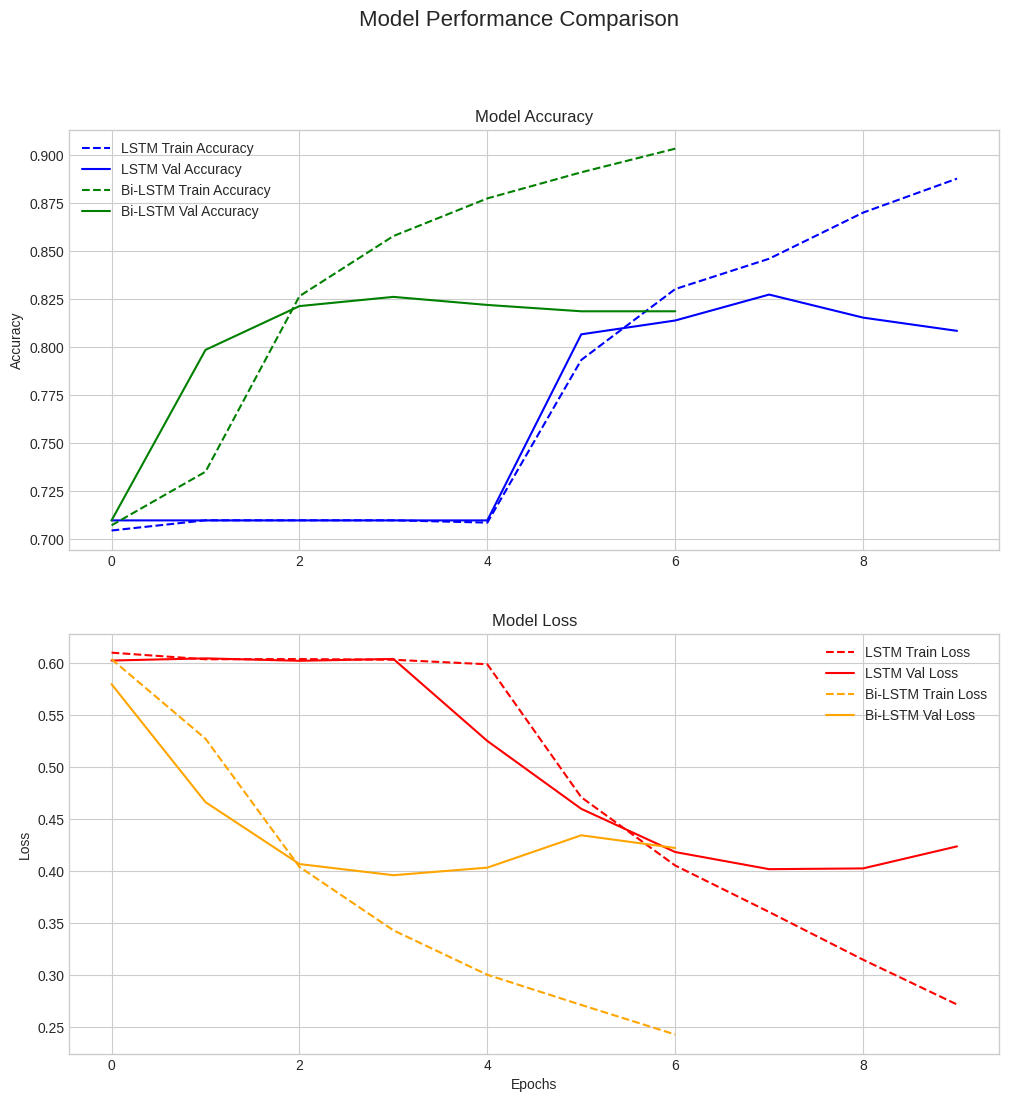

In [8]:
# Load the best performing models saved during training
best_lstm = load_model('best_lstm_model.h5')
best_bilstm = load_model('best_bilstm_model.h5')

# Evaluate LSTM on test data
loss_lstm, acc_lstm = best_lstm.evaluate(X_test_pad, Y_test, verbose=0)
print(f"LSTM Model - Test Loss: {loss_lstm:.4f}, Test Accuracy: {acc_lstm:.4f}")

# Evaluate Bi-LSTM on test data
loss_bilstm, acc_bilstm = best_bilstm.evaluate(X_test_pad, Y_test, verbose=0)
print(f"Bi-LSTM Model - Test Loss: {loss_bilstm:.4f}, Test Accuracy: {acc_bilstm:.4f}")


# Plotting training history for comparison
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot Accuracy
ax1.plot(history_lstm.history['accuracy'], label='LSTM Train Accuracy', color='blue', linestyle='--')
ax1.plot(history_lstm.history['val_accuracy'], label='LSTM Val Accuracy', color='blue')
ax1.plot(history_bilstm.history['accuracy'], label='Bi-LSTM Train Accuracy', color='green', linestyle='--')
ax1.plot(history_bilstm.history['val_accuracy'], label='Bi-LSTM Val Accuracy', color='green')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history_lstm.history['loss'], label='LSTM Train Loss', color='red', linestyle='--')
ax2.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', color='red')
ax2.plot(history_bilstm.history['loss'], label='Bi-LSTM Train Loss', color='orange', linestyle='--')
ax2.plot(history_bilstm.history['val_loss'], label='Bi-LSTM Val Loss', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()

plt.show()